# Dataset

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
data_file = pd.read_csv('dataset/combined_dataset.csv')

In [10]:
data_file.head(5)

,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label
0,www.voting-yahoo.com,10000000,0,0,0,20,0,0,1,20,2,1
1,www.zvon.org/xxl/WSDL1.1/Output/index.html,194914,0,1,7305,42,0,0,0,12,2,0
2,tecportais.com/file-security-update-infonfmati...,10000000,0,0,0,155,0,0,0,14,1,1
3,bima.astro.umd.edu/nemo/linuxastro/,7001,0,0,0,35,0,0,0,18,3,0
4,huarui-tec.com/js/?us.battle.net/login/en/?ref...,10000000,0,1,730,79,0,0,1,14,1,1


In [11]:
#Checking for null values
data_file.isna().any()

domain            False
ranking           False
isIp              False
valid             False
activeDuration    False
urlLen            False
is@               False
isredirect        False
haveDash          False
domainLen         False
nosOfSubdomain    False
label             False
dtype: bool

In [12]:
#Checking the distribution of data
print(data_file['label'].value_counts())
print(data_file.shape)

1    55914
0    39996
Name: label, dtype: int64
(95910, 12)


# Cleaning and preprocessing of Questions

### Preprocessing

1. Remove Spcial characters from domain and space in between them
2. Convert all the characters into small letters

In [35]:
import re
import string
def remove_characters(row):
    chars = re.escape(string.punctuation)
    return re.sub(r'['+chars+']', ' ',row)

data_file['domain'] = data_file['domain'].apply(remove_characters)

In [36]:
data_file.head(5)

,domain,ranking,isIp,valid,activeDuration,urlLen,is@,isredirect,haveDash,domainLen,nosOfSubdomain,label
0,www voting yahoo com,10000000,0,0,0,20,0,0,1,20,2,1
1,www zvon org xxl WSDL1 1 Output index html,194914,0,1,7305,42,0,0,0,12,2,0
2,tecportais com file security update infonfmati...,10000000,0,0,0,155,0,0,0,14,1,1
3,bima astro umd edu nemo linuxastro,7001,0,0,0,35,0,0,0,18,3,0
4,huarui tec com js us battle net login en ref...,10000000,0,1,730,79,0,0,1,14,1,1


In [41]:
#Creating string for Wordcloud of 'domain' tokens
from wordcloud import WordCloud, STOPWORDS
comment_words = '' 
stopwords = set(STOPWORDS) 
for val in data_file['domain']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords=stopwords,
                min_font_size = 10).generate(comment_words)

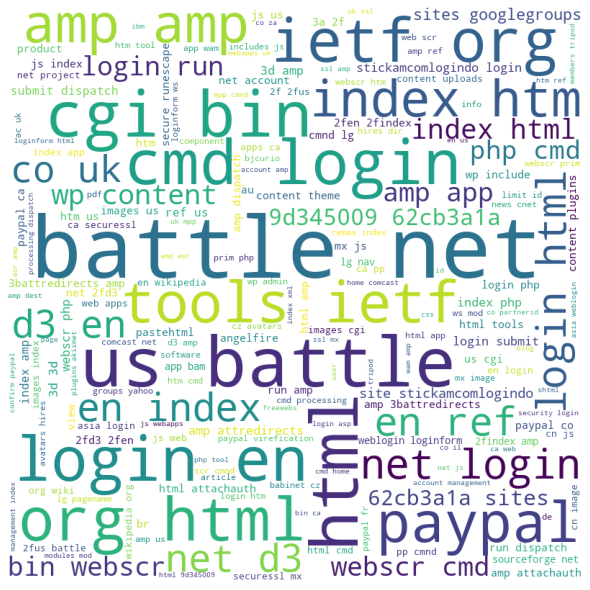

In [42]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [43]:
data_file.shape

(95910, 12)

In [44]:
data_file_x = data_file.drop(['label'], axis=1)
data_file_y = data_file['label']

In [47]:
#Dividing the dataset into train, val and test datasets
train_df_x = data_file_x[:60000]
train_df_y = data_file_y[:60000]
val_df_x = data_file_x[60000:78000]
val_df_y = data_file_y[60000:78000]
test_df_x = data_file_x[78000:]
test_df_y = data_file_y[78000:]

In [53]:
train_domain = train_df_x['domain']
val_domain = val_df_x['domain']
test_domain = test_df_x['domain']

In [58]:
#Drop 'domain' from dataset since we are converting it into bag of words
train_df_x = train_df_x.drop(['domain'], axis=1)
val_df_x = val_df_x.drop(['domain'], axis=1)
test_df_x = test_df_x.drop(['domain'], axis=1)

In [59]:
print(train_df_x.shape, val_df_x.shape, test_df_x.shape)
print(train_df_y.shape, val_df_y.shape, test_df_y.shape)

(60000, 10) (18000, 10) (17910, 10)
(60000,) (18000,) (17910,)


### Bag Of Words

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_bow = count_vect.fit_transform(train_domain)
X_val_bow = count_vect.transform(val_domain)
X_test_bow = count_vect.transform(test_domain)
feature_names_bow = count_vect.get_feature_names()
print(X_train_bow.shape)
print(X_val_bow.shape)
print(X_test_bow.shape)

(60000, 75926)
(18000, 75926)
(17910, 75926)


In [65]:
#Stacking the BoW features and other features from dataset
from scipy.sparse import hstack
bow_final_train_x = hstack((X_train_bow, train_df_x))
bow_final_val_x = hstack((X_val_bow, val_df_x))
bow_final_test_x = hstack((X_test_bow, test_df_x))

In [66]:
#Final shape of dataset will be 75926 features of domain plus 10 features of dataset. Therefore 75936 features
bow_final_train_x.shape
bow_final_val_x.shape
bow_final_test_x.shape

(17910, 75936)

### Random Forest on Bag Of Words dataset

In [68]:
from scipy.sparse import vstack
X_train_val = vstack((bow_final_train_x, bow_final_val_x))
Y_train_val = pd.concat([train_df_y, val_df_y], axis= 0)

In [69]:
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
 'max_depth': [4, 8, 16, 32],
 'n_estimators': [1, 2, 5, 10, 50, 100, 200]
}
t1 = datetime.datetime.now()
rf = RandomForestClassifier(n_jobs=-1)
clf = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = 'roc_auc')
clf.fit(X_train_val,Y_train_val)
print("time required = ", datetime.datetime.now() - t1)

time required =  0:02:36.378636


In [76]:
clf.best_params_

{'max_depth': 32, 'n_estimators': 200}

In [78]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = clf.best_params_['max_depth'], 
                                n_estimators=clf.best_params_['n_estimators'])
rf_clf.fit(X_train_val,Y_train_val)
bow_test_proba = rf_clf.predict_proba(bow_final_test_x)
bow_train_proba = rf_clf.predict_proba(X_train_val)
print("Train proba", bow_train_proba)
print("Test proba", bow_test_proba)

Train proba [[0.44516179 0.55483821]
 [0.6702516  0.3297484 ]
 [0.1299788  0.8700212 ]
 ...
 [0.46353111 0.53646889]
 [0.68620469 0.31379531]
 [0.70828539 0.29171461]]
Test proba [[0.11612594 0.88387406]
 [0.62501472 0.37498528]
 [0.64250366 0.35749634]
 ...
 [0.38517195 0.61482805]
 [0.64828961 0.35171039]
 [0.10320608 0.89679392]]


In [82]:
print("Top 20 Important Features")
d = sorted(list(zip(count_vect.get_feature_names(), rf_clf.feature_importances_ )), key=lambda x: x[1], reverse=True)[:20]
features_list = []
for (i,j) in d:
    features_list.append(i)
print(features_list)

Top 20 Important Features
['login', 'paypal', 'www', 'ietf', 'com', 'tools', 'webscr', 'images', 'dispatch', 'php', 'org', 'wp', 'html', 'edu', 'us', 'amp', 'battle', 'bin', 'js', 'd3']


In [85]:
from sklearn.metrics import roc_curve, auc
bow_fpr_train, bow_tpr_train, _ = roc_curve(Y_train_val, bow_train_proba[:, 1])
bow_fpr_test, bow_tpr_test, _ = roc_curve(test_df_y, bow_test_proba[:, 1])
bow_test_auc = auc(bow_fpr_test, bow_tpr_test)
bow_train_auc = auc(bow_fpr_train, bow_tpr_train)
print(bow_test_auc)
print(bow_train_auc)

0.9879946026923555
0.9896608193497411


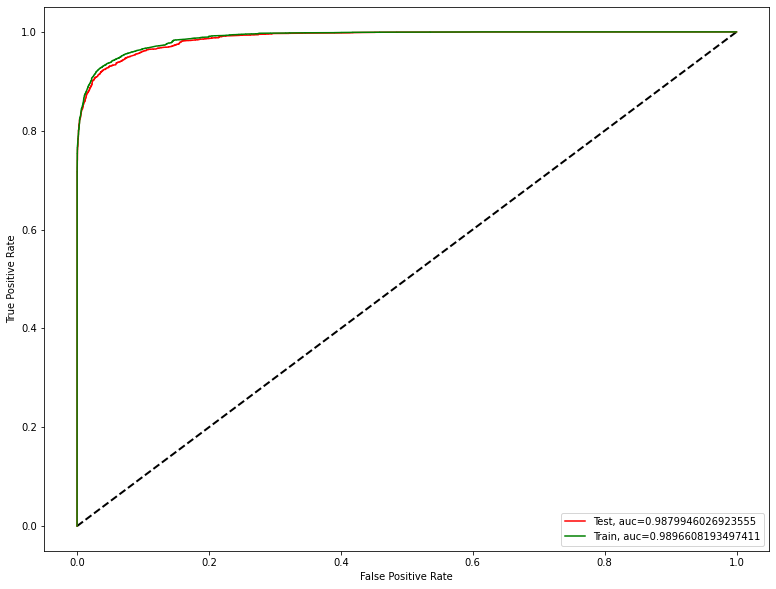

In [86]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(bow_fpr_test, bow_tpr_test, label="Test, auc="+str(bow_test_auc), color = 'red')
plt.plot(bow_fpr_train, bow_tpr_train, label="Train, auc="+str(bow_train_auc), color = 'green')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [88]:
bow_test_conf = rf_clf.predict(bow_final_test_x)
bow_train_conf = rf_clf.predict(X_train_val)

In [91]:
from sklearn.metrics import classification_report, confusion_matrix
bow_train_conf_matrix = confusion_matrix(Y_train_val, bow_train_conf)
bow_test_conf_matrix = confusion_matrix(test_df_y, bow_test_conf)
class_report = classification_report(test_df_y, bow_test_conf)
print(bow_test_conf_matrix)
print(class_report)

[[ 6651   737]
 [  415 10107]]
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7388
           1       0.93      0.96      0.95     10522

    accuracy                           0.94     17910
   macro avg       0.94      0.93      0.93     17910
weighted avg       0.94      0.94      0.94     17910



### Train Confusion Matrix

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

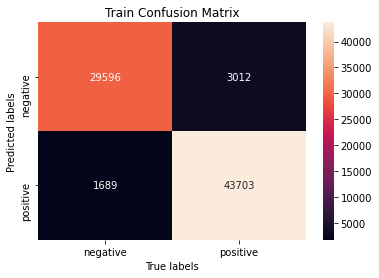

In [94]:
ax= plt.subplot()
sns.heatmap(bow_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

### Test Confusion Matrix

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

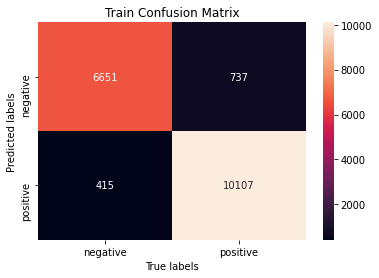

In [95]:
ax= plt.subplot()
sns.heatmap(bow_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])